#Part 2: The Fast Gradient Method (FGM)

In [ ]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fast_gradient_method = FastGradientMethod(wrap, sess=sess)

#Attack parameters
fgm_params = {'eps':0.25,
              'clip_min':0.,
              'clip_max':1.}

#Generate adversarial data
fgm_attack_data_train = fast_gradient_method.generate_np(data_train, **fgm_params)
fgm_attack_data_test = fast_gradient_method.generate_np(data_test, **fgm_params)

#Evaluate accuracy on target classifier 
fgm_scores = classifier.evaluate(fgm_attack_data_test, labels_test)
print(f'Testing accuracy on Generated Adversarial Perturbations test set is {fgm_scores[1]*100}%')


10000/10000 [==============================] - 1s 56us/step
Testing accuracy on Generated Adversarial Perturbations test set is 5.559999868273735%


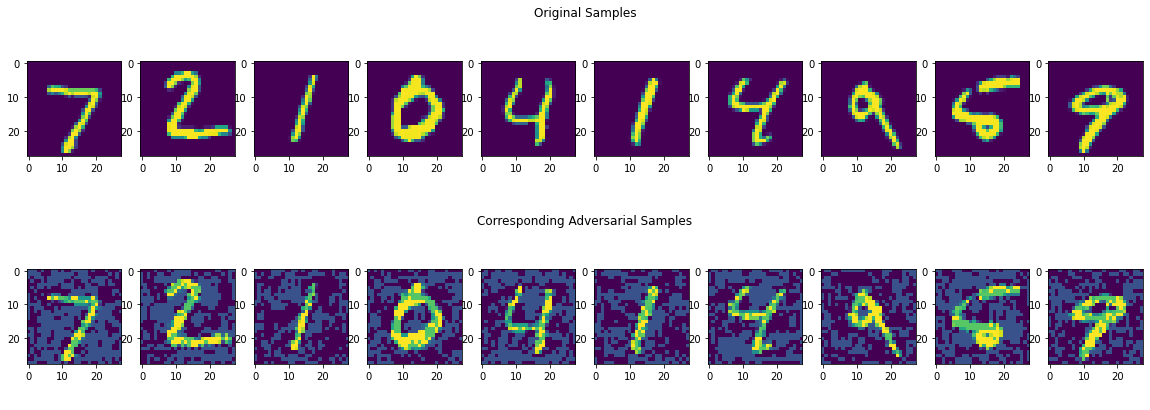

In [ ]:
#Show ten original samples and their corresponding adversarial samples
fig, axes = plt.subplots(2, 10, figsize=(20, 7))
grids = plt.GridSpec(2, 1)
titles = ['Original Samples', 'Corresponding Adversarial Samples']

for i in range(2):
  row = fig.add_subplot(grids[i])
  row.set_title(titles[i])
  row.set_axis_off()

for i in range(10):
  axes[0][i].imshow(data_test[i].reshape(28, 28))
  axes[1][i].imshow(fgm_attack_data_test[i].reshape(28, 28))

In [ ]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation='relu', kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(100, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(400, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
ae = autoencoder()
ae.compile(loss='mse', optimizer='adam')

ae_metadata = ae.fit(fgm_attack_data_train, data_train,
                     validation_data=(fgm_attack_data_test, data_test),
                     epochs=50,
                     batch_size=256,
                     shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0624 - val_loss: 0.0345
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0272 - val_loss: 0.0222
Epoch 3/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0202 - val_loss: 0.0179
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0169 - val_loss: 0.0155
Epoch 5/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0150 - val_loss: 0.0141
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0127 - val_loss: 0.0122
Epoch 8/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0119 - val_loss: 0.0115
Epoch 9/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0113 - val_loss: 0.0111
Epoch

In [ ]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
fgm_adversarial_examples = fast_gradient_method.generate_np(data_train, **fgm_params)

# Obtain reconstruction errors on training set and determine a threshold 
reconstructions = ae.predict(fgm_adversarial_examples)
error = keras.losses.mean_squared_error(fgm_adversarial_examples, reconstructions)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold = error.min()
print(f'Threshold error: {threshold}')

# Calculate error of adversarial testing set
test_reconstructions = ae.predict(fgm_attack_data_test)
test_error = keras.losses.mean_squared_error(fgm_attack_data, test_reconstructions)
test_error = test_error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
true_positive_count = np.count_nonzero(test_error > threshold)

# Print number of true positive samples
print(f'Total number of true positive samples = {true_positive_count}')

# Determine false positives on benign testing set
original_test_reconstructions = ae.predict(data_test)
original_test_error = keras.losses.mean_squared_error(data_test, original_test_reconstructions)
original_test_error = original_test_error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
false_positive_count = np.count_nonzero(original_test_error > threshold)
    
# Print number of false positive samples
print(f'Total number of false positive samples = {false_positive_count}') 

Threshold error: 0.02181132882833481
Total number of true positive samples = 10000
Total number of false positive samples = 24
